In [ ]:
import os
from dotenv import load_dotenv

# Load HF token from .env
load_dotenv()
hf_token = os.getenv('HUGGINGFACE_TOKEN')

# Login to HuggingFace
from huggingface_hub import login
login(token=hf_token)

Testing dynamic cache with CPU decode=False:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1b' with cache strategy 'dynamic'
/home/jbi4001/miniforge3/envs/llm_bench/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jbi4001/miniforge3/envs/llm_bench/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect

Testing dynamic cache with CPU decode=True:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1b' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1b' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1b' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1b' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU


Testing offloaded cache with CPU decode=False:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1b' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1b' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1b' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1b' with cache strategy 'offloaded'
IN

Testing offloaded cache with CPU decode=True:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1b' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1b' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1b' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1b' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU


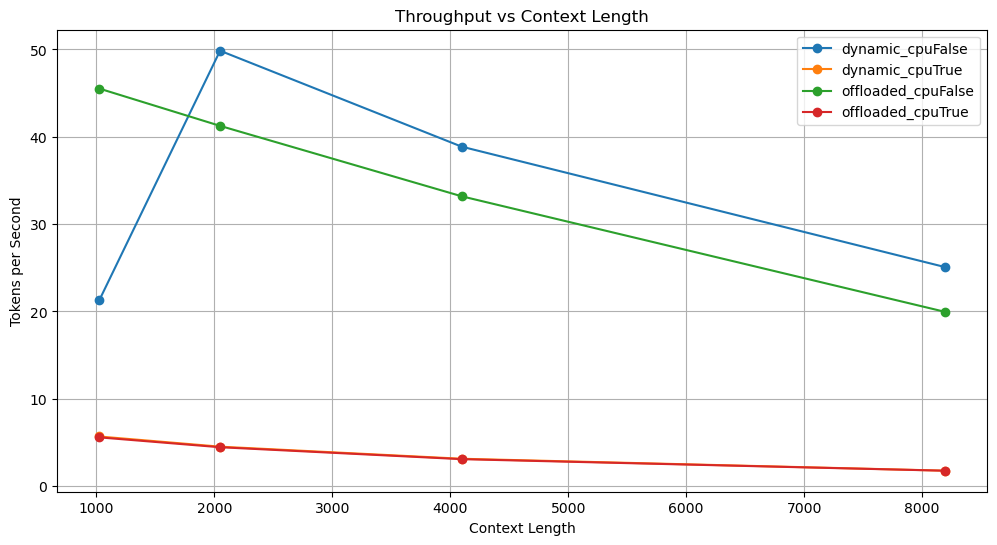

In [1]:
import torch
import numpy as np
import time
import logging
import psutil
from dataclasses import dataclass
from typing import Dict, Optional, List, Union, Tuple, Any
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer,
    PretrainedConfig,
    Cache,
    DynamicCache, 
    OffloadedCache
)

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class ModelConfig:
    """Configuration for model loading and inference"""
    model_name: str = "meta-llama/Llama-3.2-1b"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    cache_strategy: str = "dynamic"  # dynamic or offloaded
    use_cpu_decode: bool = False
    torch_dtype: torch.dtype = torch.float16
    
class HybridLlamaInference:
    """Enhanced LLaMA inference with CPU decode support"""
    def __init__(self, config: ModelConfig):
        self.config = config
        self.metrics_tracker = None
        self.setup()
    
    def setup(self):
        """Initialize model with CPU decode if specified"""
        logger.info(f"Loading model '{self.config.model_name}' with cache strategy '{self.config.cache_strategy}'")
        
        # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
        
        # Load model
        self.model = AutoModelForCausalLM.from_pretrained(
            self.config.model_name,
            torch_dtype=self.config.torch_dtype,
            device_map="auto" if not self.config.use_cpu_decode else None,
            low_cpu_mem_usage=True
        )

        self.model = self.model.float()
        
        # Move decoder to CPU if specified
        if self.config.use_cpu_decode:
            logger.info("Moving decoder to CPU...")
            if hasattr(self.model, 'decoder'):
                self.model.decoder.to("cpu")
            else:
                # For models without explicit decoder attribute
                self.model.to("cpu")
            logger.info("Decoder moved to CPU")
                
        self.tokenizer = AutoTokenizer.from_pretrained(self.config.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            
        # Initialize cache based on strategy
        self.cache = DynamicCache() if self.config.cache_strategy == "dynamic" else OffloadedCache()
    
    def run_inference(
        self,
        input_text: str,
        max_new_tokens: int = 100,
        temperature: float = 1.0,
    ) -> Dict:
        """Run inference with enhanced metrics tracking"""
        inputs = self.tokenizer(
            input_text, 
            return_tensors="pt",
            truncation=True
        ).to(self.config.device if not self.config.use_cpu_decode else "cpu")
        
        try:
            with torch.inference_mode():
                # Prefill phase
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                    
                input_ids = inputs["input_ids"]
                attention_mask = inputs["attention_mask"]
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    past_key_values=self.cache,
                    use_cache=True
                )
                
                # For simplicity, just do greedy decoding for now
                generated_ids = input_ids
                
                for _ in range(max_new_tokens):
                    next_token_logits = outputs.logits[:, -1, :] / temperature
                    next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
                    generated_ids = torch.cat([generated_ids, next_token], dim=-1)
                    
                    # Prepare next inputs
                    attention_mask = torch.cat([attention_mask, attention_mask.new_ones((1, 1))], dim=-1)
                    
                    outputs = self.model(
                        input_ids=next_token,
                        attention_mask=attention_mask,
                        past_key_values=self.cache,
                        use_cache=True
                    )
                    
                    if next_token.item() == self.tokenizer.eos_token_id:
                        break
                        
                generated_text = self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
                
                # Get memory stats
                memory_stats = {
                    'gpu_allocated': torch.cuda.memory_allocated() / 1024**2 if torch.cuda.is_available() else 0,
                    'gpu_reserved': torch.cuda.memory_reserved() / 1024**2 if torch.cuda.is_available() else 0,
                    'cpu_memory': psutil.Process().memory_info().rss / 1024**2
                }
                
                return {
                    "text": generated_text,
                    "memory_stats": memory_stats
                }
                
        except Exception as e:
            logger.error(f"Generation failed: {e}")
            raise

    def cleanup(self):
        """Clean up resources with enhanced memory management"""
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        # Clear model and cache
        if hasattr(self, 'model'):
            self.model.cpu()
            del self.model
        if hasattr(self, 'cache'):
            del self.cache
            
        # Thorough CUDA cleanup
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.synchronize()
            
        # Force garbage collection
        import gc
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

class EnhancedDocumentLoader:
    """Simplified document loader for testing"""
    def __init__(self, base_text: str = "This is a test document. It contains multiple sentences with varying content. "):
        self.base_text = base_text
    
    def load_chunk(self, chunk_size: int = 1000) -> str:
        # Create more varied content with proper sentence boundaries
        sentences = self.base_text.split('. ')
        result = []
        current_length = 0
        while current_length < chunk_size:
            for sentence in sentences:
                result.append(sentence + ". ")
                current_length += len(sentence) + 2
                if current_length >= chunk_size:
                    break
        return "".join(result)

def run_context_length_test(
    config: ModelConfig,
    context_lengths: List[int] = [1024, 2048, 4096, 8192],
    max_new_tokens: int = 20
) -> Dict[str, List[Dict]]:
    """Test different context lengths with given configuration"""
    results = []
    
    for length in tqdm(context_lengths, desc=f"Testing {config.cache_strategy} cache with CPU decode={config.use_cpu_decode}"):
        try:
            # Initialize model
            llm = HybridLlamaInference(config)
            
            # Ensure CUDA is clean before each run
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.reset_peak_memory_stats()
                torch.cuda.synchronize()
            
            # Generate input text using document loader
            doc_loader = EnhancedDocumentLoader()
            input_text = doc_loader.load_chunk(chunk_size=length)
            
            # Run inference
            start_time = time.perf_counter()
            result = llm.run_inference(input_text, max_new_tokens=max_new_tokens)
            end_time = time.perf_counter()
            
            # Collect metrics
            metrics = {
                'context_length': length,
                'latency': end_time - start_time,
                'tokens_per_second': max_new_tokens / (end_time - start_time),
                **result['memory_stats']
            }
            
            results.append(metrics)
            
        except Exception as e:
            logger.error(f"Error testing length {length}: {str(e)}")
            continue
            
        finally:
            if 'llm' in locals():
                llm.cleanup()
    
    return results

# Example usage:
if __name__ == "__main__":
    # Test configurations
    configs = [
        ModelConfig(cache_strategy="dynamic", use_cpu_decode=False),  # Baseline
        ModelConfig(cache_strategy="dynamic", use_cpu_decode=True),   # CPU decode
        ModelConfig(cache_strategy="offloaded", use_cpu_decode=False), # Offloaded cache
        ModelConfig(cache_strategy="offloaded", use_cpu_decode=True)  # Hybrid
    ]
    
    context_lengths = [1024, 2048, 4096, 8192]
    all_results = {}
    
    for config in configs:
        name = f"{config.cache_strategy}_cpu{config.use_cpu_decode}"
        all_results[name] = run_context_length_test(config, context_lengths)
        
    # Plot results
    plt.figure(figsize=(12, 6))
    for name, results in all_results.items():
        lengths = [r['context_length'] for r in results]
        throughput = [r['tokens_per_second'] for r in results]
        plt.plot(lengths, throughput, marker='o', label=name)
    
    plt.xlabel('Context Length')
    plt.ylabel('Tokens per Second')
    plt.title('Throughput vs Context Length')
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
import torch
import numpy as np
import time
import logging
import psutil
from dataclasses import dataclass
from typing import Dict, Optional, List, Union, Tuple, Any
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer,
    PretrainedConfig,
    Cache,
    DynamicCache, 
    OffloadedCache
)

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class ModelConfig:
    """Configuration for model loading and inference"""
    model_name: str = "meta-llama/Llama-3.2-1B"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    cache_strategy: str = "dynamic"  # dynamic or offloaded
    use_cpu_decode: bool = False
    torch_dtype: torch.dtype = torch.float16
    
class HybridLlamaInference:
    """Enhanced LLaMA inference with CPU decode support"""
    def __init__(self, config: ModelConfig):
        self.config = config
        self.metrics_tracker = None
        self.setup()
    
    def setup(self):
        """Initialize model with CPU decode if specified"""
        logger.info(f"Loading model '{self.config.model_name}' with cache strategy '{self.config.cache_strategy}'")
        
        # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
        
        # Load model
        self.model = AutoModelForCausalLM.from_pretrained(
            self.config.model_name,
            torch_dtype=self.config.torch_dtype,
            device_map="auto" if not self.config.use_cpu_decode else None,
            low_cpu_mem_usage=True
        )

        self.model = self.model.float()
        
        # Move decoder to CPU if specified
        if self.config.use_cpu_decode:
            logger.info("Moving decoder to CPU...")
            if hasattr(self.model, 'decoder'):
                self.model.decoder.to("cpu")
            else:
                # For models without explicit decoder attribute
                self.model.to("cpu")
            logger.info("Decoder moved to CPU")
                
        self.tokenizer = AutoTokenizer.from_pretrained(self.config.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            
        # Initialize cache based on strategy
        self.cache = DynamicCache() if self.config.cache_strategy == "dynamic" else OffloadedCache()
    
    def run_inference(
        self,
        input_text: str,
        max_new_tokens: int = 100,
        temperature: float = 1.0,
    ) -> Dict:
        """Run inference with enhanced metrics tracking"""
        inputs = self.tokenizer(
            input_text, 
            return_tensors="pt",
            truncation=True
        ).to(self.config.device if not self.config.use_cpu_decode else "cpu")
        
        try:
            with torch.inference_mode():
                # Prefill phase
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                    
                input_ids = inputs["input_ids"]
                attention_mask = inputs["attention_mask"]
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    past_key_values=self.cache,
                    use_cache=True
                )
                
                # For simplicity, just do greedy decoding for now
                generated_ids = input_ids
                actual_tokens_generated = 0
                
                for _ in range(max_new_tokens):
                    next_token_logits = outputs.logits[:, -1, :] / temperature
                    next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
                    generated_ids = torch.cat([generated_ids, next_token], dim=-1)
                    actual_tokens_generated +=1
                    
                    # Prepare next inputs
                    attention_mask = torch.cat([attention_mask, attention_mask.new_ones((1, 1))], dim=-1)
                    
                    outputs = self.model(
                        input_ids=next_token,
                        attention_mask=attention_mask,
                        past_key_values=self.cache,
                        use_cache=True
                    )
                    
                    if next_token.item() == self.tokenizer.eos_token_id:
                        break
                        
                generated_text = self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
                
                # Get memory stats
                memory_stats = {
                    'gpu_allocated': torch.cuda.memory_allocated() / 1024**2 if torch.cuda.is_available() else 0,
                    'gpu_reserved': torch.cuda.memory_reserved() / 1024**2 if torch.cuda.is_available() else 0,
                    'cpu_memory': psutil.Process().memory_info().rss / 1024**2,
                    'tokens_generated': actual_tokens_generated
                }
                
                return {
                    "text": generated_text,
                    "memory_stats": memory_stats
                }
                
        except Exception as e:
            logger.error(f"Generation failed: {e}")
            raise

    def cleanup(self):
        """Clean up resources with enhanced memory management"""
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        # Clear model and cache
        if hasattr(self, 'model'):
            self.model.cpu()
            del self.model
        if hasattr(self, 'cache'):
            del self.cache
            
        # Thorough CUDA cleanup
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.synchronize()
            
        # Force garbage collection
        import gc
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

class EnhancedDocumentLoader:
    """Simplified document loader for testing"""
    def __init__(self, base_text: str = "This is a test document. It contains multiple sentences with varying content. "):
        self.base_text = base_text
    
    def load_chunk(self, chunk_size: int = 1000) -> str:
        # Create more varied content with proper sentence boundaries
        sentences = self.base_text.split('. ')
        result = []
        current_length = 0
        while current_length < chunk_size:
            for sentence in sentences:
                result.append(sentence + ". ")
                current_length += len(sentence) + 2
                if current_length >= chunk_size:
                    break
        return "".join(result)

def run_comprehensive_test(
    config: ModelConfig,
    context_lengths: List[int] = [1024, 2048, 4096, 8192],
    output_lengths: List[int] = [20, 50, 100, 200],
    warmup: bool = True
) -> Dict[str, List[Dict]]:
    """Run comprehensive benchmark testing different context and output lengths"""
    results = []
    
    # Optional warmup run
    if warmup:
        logger.info("Performing warmup run...")
        try:
            llm = HybridLlamaInference(config)
            warmup_text = EnhancedDocumentLoader().load_chunk(chunk_size=1024)
            llm.run_inference(warmup_text, max_new_tokens=20)
            llm.cleanup()
        except Exception as e:
            logger.warning(f"Warmup run failed: {e}")
    
    # Main benchmark runs
    for context_len in tqdm(context_lengths, desc=f"Testing {config.cache_strategy} cache with CPU decode={config.use_cpu_decode}"):
        for output_len in tqdm(output_lengths, desc=f"Output length", leave=False):
            try:
                # Initialize model and ensure clean GPU state
                llm = HybridLlamaInference(config)
                
                # Generate input text using document loader
                doc_loader = EnhancedDocumentLoader()
                input_text = doc_loader.load_chunk(chunk_size=context_len)
                
                # Run inference with specific output length
                start_time = time.perf_counter()
                result = llm.run_inference(input_text, max_new_tokens=output_len)
                end_time = time.perf_counter()
                
                # Collect metrics
                metrics = {
                    'context_length': context_len,
                    'target_output_length': output_len,  # Added to track target length
                    'actual_output_length': result['memory_stats']['tokens_generated'],
                    'total_latency': end_time - start_time,
                    'tokens_per_second': result['memory_stats']['tokens_generated'] / (end_time - start_time),
                    'per_token_latency': (end_time - start_time) / result['memory_stats']['tokens_generated'],
                    **result['memory_stats']
                }
                
                results.append(metrics)
                
            except Exception as e:
                logger.error(f"Error testing context_len={context_len}, output_len={output_len}: {str(e)}")
                continue
                
            finally:
                if 'llm' in locals():
                    llm.cleanup()
    
    return results

In [27]:
configs = [
    ModelConfig(cache_strategy="dynamic", use_cpu_decode=False),  # Baseline
    ModelConfig(cache_strategy="dynamic", use_cpu_decode=True),   # CPU decode
    ModelConfig(cache_strategy="offloaded", use_cpu_decode=False), # Offloaded cache
    ModelConfig(cache_strategy="offloaded", use_cpu_decode=True)  # Hybrid
]

context_lengths = [1024, 2048, 4096, 8192, 16384]
output_lengths = [20, 50, 100, 200]  # This will now actually be used
all_results = {}

for config in configs:
    name = f"{config.cache_strategy}_cpu{config.use_cpu_decode}"
    all_results[name] = run_comprehensive_test(
        config, 
        context_lengths=context_lengths,
        output_lengths=output_lengths,
        warmup=True
    )
    print(f"Finished testing {name}")

INFO:__main__:Performing warmup run...
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Testing dynamic cache with CPU decode=False:   0%|          | 0/5 [00:00<?, ?it/s]

Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accel

Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accel

Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accel

Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accel

Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:accel

Finished testing dynamic_cpuFalse


INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU


Testing dynamic cache with CPU decode=True:   0%|          | 0/5 [00:00<?, ?it/s]

Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU


Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU


Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU


Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU


Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'dynamic'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Performing warmup run...
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Finished testing dynamic_cpuTrue


Testing offloaded cache with CPU decode=False:   0%|          | 0/5 [00:00<?, ?it/s]

Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
IN

Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
IN

Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
IN

Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
IN

Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
IN

Finished testing offloaded_cpuFalse


INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU


Testing offloaded cache with CPU decode=True:   0%|          | 0/5 [00:00<?, ?it/s]

Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU


Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU


Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU


Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU


Output length:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU
INFO:__main__:Loading model 'meta-llama/Llama-3.2-1B' with cache strategy 'offloaded'
INFO:__main__:Moving decoder to CPU...
INFO:__main__:Decoder moved to CPU


Finished testing offloaded_cpuTrue


In [28]:
import json
from datetime import datetime

results_file = f"benchmark_results_initial.json"

# Save results
with open(results_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"Results saved to {results_file}")

# To load results later:
with open(results_file, 'r') as f:
    loaded_results = json.load(f)

Results saved to benchmark_results_initial.json
